In [ ]:
# #@title Download Kaggle API token from Google Drive
# import gdown
# import os
# from pathlib import Path

# gdrive_url = 'https://drive.google.com/uc?id=1P6t7O8vOjmQi3rMX0KQlgO6BT0fk2dI-'
# if not os.path.exists('kaggle.json'):
#   gdown.download(gdrive_url, 'kaggle.json', quiet=False)

# kaggle_dir = Path.home() / '.kaggle'
# kaggle_token_path = kaggle_dir / 'kaggle.json'

# if not kaggle_token_path.exists():
#   kaggle_dir.mkdir(parents=True, exist_ok=True)
#   os.rename('kaggle.json', kaggle_token_path)
#   kaggle_token_path.chmod(0o600)

# dataset_path = 'global_covid-19'
# if not os.path.exists(dataset_path):
#   os.mkdir(dataset_path)
#   !kaggle datasets download -d rohitashchandra/global-covid19-twitter-dataset --path {dataset_path} --unzip
#   gdrive_url = 'https://drive.google.com/uc?id=19Hr0PQSyqGqLLJlPaDKjMfvlbFVnYbBr'
#   os.remove(os.path.join(dataset_path, 'India.csv'))
#   gdown.download(gdrive_url, os.path.join(dataset_path, 'India.csv'), quiet=False)

In [10]:
from csv import QUOTE_NONE
import os
import pandas as pd
import random
import csv
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# from geopy.geocoders import Nominatim
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_curve, auc


In [6]:
#@title merge into one csv

# List to hold the dataframes
dataframes = []
dataset_dir = 'global_covid-19'
dataset = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir)]
# Read each CSV file with specific settings to handle quoting issues
for data in dataset:
  try:
    # Open the file with utf-8 encoding, handle errors by replacing problematic characters
    with open(data, 'r', encoding='utf-8', newline='') as file:
      df = pd.read_csv(file, on_bad_lines='skip', quoting=csv.QUOTE_MINIMAL)
      df = df.iloc[:, 1:]
  except UnicodeDecodeError:
    # Fallback to a different encoding if UTF-8 doesn't work
    with open(data, 'r', encoding='ISO-8859-1', newline='') as file:
      df = pd.read_csv(file, on_bad_lines='skip', quoting=csv.QUOTE_MINIMAL)
      df = df.iloc[:, 1:]
  dataframes.append(df)
  random_rows = df.sample(n=3)
  # Display the random rows
  print(f"Random rows from {data}:")
  display(random_rows)

# Concatenate all dataframes
combined_df = pd.concat(dataframes, ignore_index=True)

tweets_file = 'tweets.csv'

# Save the combined dataframe to a new CSV file
combined_df.to_csv(tweets_file, index=False)

# open and sample 20 rows from tweets.csv
df = pd.read_csv(tweets_file)
random_rows = df.sample(n=20)
print(f"Random rows from {tweets_file}:")
display(random_rows)

Random rows from global_covid-19\Australia.csv:


,created_at,text,user_location
219775,Fri Dec 31 17:35:25 +0000 2021,@SkySportsNews Why are people so upset about p...,Nottingham
193455,Fri Dec 31 05:58:13 +0000 2021,Senate GOP preps to nullify Biden’s vaccine ma...,Jerusalem | Washington D.C.
379195,Wed Dec 15 10:28:37 +0000 2021,RT @KittyAbsurd: Has any journo questioned the...,East Nowra New South Wales


Random rows from global_covid-19\Brazil.csv:


,created_at,text,user_location
335014,Fri Mar 05 17:28:32 +0000 2021,RT @VP: A third safe and effective vaccine is ...,Panama city
237616,Sat Aug 07 04:40:40 +0000 2021,RT @DrEricDing: PAY ATTENTION—the #DeltaVarian...,Mundo | Argentina | Europa
312129,Sat Feb 27 01:13:47 +0000 2021,RT @AllyBrooke: 5 years since #WorkFromHome wa...,"Acaiaca, Brasil"


Random rows from global_covid-19\Indonesia.csv:


,created_at,text,user_location
87864,Sat Mar 06 04:18:11 +0000 2021,RT @jiggyjayy2: Yall cannot continuously atten...,Indonesia
31635,Fri Dec 24 08:32:02 +0000 2021,Indonesia Adds Quarantine Wards to Anticipate ...,"Jakarta, Indonesia"
185622,Fri Dec 24 23:04:20 +0000 2021,RT @soompi: BTS' Suga Diagnosed With COVID-19\...,Indonesia


Random rows from global_covid-19\Japan.csv:


,created_at,text,user_location
390298,Mon Aug 30 10:42:08 +0000 2021,@smolyoongiiii covid get the hell out,"Kaizuka-shi, Osaka"
383520,Thu Apr 15 13:32:59 +0000 2021,RT @jaybeeyxe: A member of my wife’s family di...,Trinidad and Tobago
34241,Fri Dec 24 08:38:50 +0000 2021,RT @SeanGoss31: The vaccine rollout has come t...,"Greenstone Hill, south africa"


Random rows from tweets.csv:


,created_at,text,user_location
1024220,1351108980140077058,RT @BT21_: Happiest when we're together. ❤️\n\...,"Central Java, Indonesia"
783725,Thu Mar 18 01:41:03 +0000 2021,RT @NYHammond: New post:\n\nThe Cuomo administ...,Lurking in the Potential
556564,Fri Dec 24 14:18:18 +0000 2021,RT @brat2381: I keep trying to tell folks to w...,"Houston, TX; Copenhagen, DK"
1405515,Thu Mar 25 00:58:24 +0000 2021,@trinijournalist Really feeling this 3rd world...,Trinidad and Tobago
792173,Sat May 01 09:17:27 +0000 2021,The United States Provides Additional Funding ...,"Butwal, Nepal / Ex Sao Paulo"
253881,Sun Jan 02 12:52:40 +0000 2022,"RT @JNkengasong: Two years,&lt;100 cases of th...","Adelaide, South Australia"
80013,Fri Dec 24 14:19:41 +0000 2021,RT @PeterWMurphy1: Remember: No one from the F...,"Perth, Western Australia"
109776,Mon Dec 27 08:30:35 +0000 2021,@catherine___c It’s almost like a pandemic cha...,"Queensland, Australia"
1268474,Mon Feb 08 12:43:44 +0000 2021,Enterprise hits and misses - taking stock of A...,"Hannover, Germany"
203777,Fri Dec 31 09:16:10 +0000 2021,RT @RageSheen: A short thread on the magnitude...,"Darwin, Northern Territory"


In [7]:
df = pd.read_csv('tweets.csv')
df = df.dropna()
df.sample(10)

,created_at,text,user_location
1164161,Fri Dec 17 15:37:25 +0000 2021,RT @FiredUpNET: Right Now On FiredUp New Show ...,"Stoney Creek, ON"
268896,Sun Jan 02 21:33:58 +0000 2022,RT @BNODesk: Israel formally approves 4th dose...,"Redfern, Sydney"
448312,Fri Dec 10 22:46:30 +0000 2021,RT @easy_jonathan: @papapiols @MyNameIsKatarin...,"manama, Bahrain"
101021,Mon Dec 27 04:59:33 +0000 2021,RT @Feynman_19: Currently in middle America.\n...,"Orange City, IA"
1090824,Wed Dec 29 13:04:07 +0000 2021,Covid-19: Your complete guide to caring for so...,"udala,college road tanakasahi"
131183,Mon Dec 27 21:30:38 +0000 2021,⁦@RalphNortham⁩ #VAGov ⁦@VDHgov⁩ ⁦⁦@CDCgov⁩ - ...,Richmond VA
476451,Wed Dec 29 16:30:02 +0000 2021,RT @Craig_A_Spencer: I’ve seen a lot of Covid ...,São Paulo
81373,Fri Dec 24 15:32:55 +0000 2021,RT @ManchesterDave: @HyapatiaLee I'm immunocom...,"Portland, OR"
481630,Mon Nov 29 06:08:46 +0000 2021,RT @israel_massa: *NIH DIRECTOR COLLINS: CURRE...,"São Paulo, Brasil"
576056,Sat Sep 11 01:13:19 +0000 2021,"RT @pamqueri: ""You have never said anything go...",Macau


In [10]:
# Assuming df is your DataFrame
df['text'] = df['text'].astype(str)
# Remove URLs
df['cleaned_text'] = df['text'].apply(lambda x: re.sub(r'http\S+', '', x))
# Remove mentions
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'@\w+', '', x))
# Remove hashtags
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'#\w+', '', x))
# Remove punctuation
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
# Remove stop words
stop_words = set(stopwords.words('english'))
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
# Remove 'RT'
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() != 'rt']))
# Tokenize text
df['tokens'] = df['cleaned_text'].apply(word_tokenize)
# Lemmatize tokens
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


In [16]:
def is_valid_date(date_str):
    try:
        pd.to_datetime(date_str)
        return True
    except (ValueError, OverflowError):
        return False

# Count and drop invalid dates
def count_and_drop_invalid_dates(df, column):
    # Identify valid dates
    valid_dates = df[column].apply(is_valid_date)
    
    # Count invalid dates
    invalid_date_count = (~valid_dates).sum()
    
    # Drop rows with invalid dates
    df_valid = df[valid_dates].reset_index(drop=True)
    
    return df_valid, invalid_date_count

# Apply the function
df, invalid_date_count = count_and_drop_invalid_dates(df, 'created_at')

print(f"Number of rows with invalid dates: {invalid_date_count}")

# Display the processed DataFrame
print("Processed DataFrame without invalid dates:")
display(df.sample(10))

Number of rows with invalid dates: 0
Processed DataFrame without invalid dates:


,created_at,text,user_location,cleaned_text,tokens,day_of_week,month,year,text_length
936,2021-04-04 07:12:28+00:00,RT @JulesBoykoff: The #OlympicTorchRelay shoul...,"Okinawa,JPN",The cancelled amid sharp rise cases Osaka says...,"[The, cancelled, amid, sharp, rise, case, Osak...",6,4,2021,74
386,2021-06-23 05:15:06+00:00,RT @ANI: The University of Oxford has said it ...,"Barrackpur, Kolkata",The University Oxford said testing antiparasit...,"[The, University, Oxford, said, testing, antip...",2,6,2021,99
501,2021-08-11 05:34:31+00:00,RT @DisabilityStor1: VACCINES HAVE ALWAYS BEEN...,Surabaya,VACCINES HAVE ALWAYS BEEN REQUIRED FOR INTERNA...,"[VACCINES, HAVE, ALWAYS, BEEN, REQUIRED, FOR, ...",2,8,2021,116
573,2021-12-31 09:37:19+00:00,RT @florian_krammer: @RickABright I lost faith...,"Wien / Vienna, Republik Europa",I lost faith ability stop pandemics pandemic w...,"[I, lost, faith, ability, stop, pandemic, pand...",4,12,2021,85
406,2021-12-23 00:01:46+00:00,RT @Canadia32542180: If I had 3 polio vaccines...,Rio de Janeiro,If I 3 polio vaccines 9 months still got polio...,"[If, I, 3, polio, vaccine, 9, month, still, go...",3,12,2021,72
242,2021-08-13 08:15:04+00:00,RT @DeedeeKIRO7: The FBI is warning you about ...,somewhere at a music festival,The FBI warning harsh penalty come faking COVI...,"[The, FBI, warning, harsh, penalty, come, faki...",4,8,2021,76
757,2021-12-29 16:37:31+00:00,@jeffreyatucker nails it again. ...,"Scottsdale, AZ",nails How COVID Lockdown Fanatics Took Over Th...,"[nail, How, COVID, Lockdown, Fanatics, Took, O...",2,12,2021,53
423,2022-01-02 13:16:31+00:00,"RT @DistrictAdm_FBD: #Update | ""Mahamari Alert...",Ballabgarh Faridabad,Mahamari AlertSurakshit Haryana period extende...,"[Mahamari, AlertSurakshit, Haryana, period, ex...",6,1,2022,104
128,2021-12-08 08:16:29+00:00,RT @jburnmurdoch: Key points from latest Omicr...,Sydney 🇦🇺 & Keystone 🇺🇸,Key points latest Omicron immune escape study ...,"[Key, point, latest, Omicron, immune, escape, ...",2,12,2021,102
510,2021-12-27 12:19:57+00:00,RT @chrischirp: Burnout and trauma need to be ...,"Hokkaido,Japan",Burnout trauma need acknowledged planned NHS c...,"[Burnout, trauma, need, acknowledged, planned,...",0,12,2021,77


In [17]:

df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y')
df['day_of_week'] = df['created_at'].dt.dayofweek
df['month'] = df['created_at'].dt.month
df['year'] = df['created_at'].dt.year


In [18]:
df['text_length'] = df['cleaned_text'].apply(len)


In [20]:
df.sample(10)

,created_at,text,user_location,cleaned_text,tokens,day_of_week,month,year,text_length
741,2022-01-02 20:05:19+00:00,@calimay82 I think they have more injury probl...,"Bettendorf, IA",I think injury problems covid,"[I, think, injury, problem, covid]",6,1,2022,29
805,2021-12-29 16:20:06+00:00,RT @BillMonty_: One depressing thing about COV...,"Portland, OR",One depressing thing COVID perhaps necessary f...,"[One, depressing, thing, COVID, perhaps, neces...",2,12,2021,81
42,2021-04-15 12:14:36+00:00,"RT @alyssabcolman: When I get a fun idea, I ru...",Trinidad and Tobago,When I get fun idea I run Authors debuted pand...,"[When, I, get, fun, idea, I, run, Authors, deb...",3,4,2021,78
391,2021-12-08 08:19:17+00:00,@Fiona_M_Russell I remember there was a 2 week...,"Melbourne, Victoria",I remember 2 week lockdown 27th May prior love...,"[I, remember, 2, week, lockdown, 27th, May, pr...",2,12,2021,186
86,2021-09-10 23:53:42+00:00,@RawhideKobe wash your god damn hands,"Santiago, Rep. Dominicana",wash god damn hands,"[wash, god, damn, hand]",4,9,2021,19
366,2021-12-27 19:24:52+00:00,RT @AnneBoleynVIII: @Chateausherrill @bader_di...,"Richmond, VA",I think you’ve put words what’s nagging … “the...,"[I, think, you, ’, ve, put, word, what, ’, s, ...",0,12,2021,63
428,2021-12-29 09:20:41+00:00,RT @propublica: New: The pandemic killed so ma...,"Bensalem, PA",New The pandemic killed many dialysis patients...,"[New, The, pandemic, killed, many, dialysis, p...",2,12,2021,96
8,2021-12-23 00:15:15+00:00,@cicatrizelysian Vaccine didn't work it seems,Miyuki's kinda based imo,Vaccine didnt work seems,"[Vaccine, didnt, work, seems]",3,12,2021,24
778,2022-01-02 22:09:27+00:00,RT @jean15849180: Frydenberg is at Torquay at ...,"Melbourne, Victoria",Frydenberg Torquay moment bodyguards spruiking...,"[Frydenberg, Torquay, moment, bodyguard, sprui...",6,1,2022,83
362,2021-09-02 07:45:29+00:00,RT @MTWAUganda: The effects of the pandemic ha...,Tokyo and Yokohama,The effects pandemic manifested multiple lockd...,"[The, effect, pandemic, manifested, multiple, ...",3,9,2021,98


In [24]:
# Load and prepare the lexicon

lexicon_path = 'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
lexicon_url = 'https://drive.google.com/file/d/1DPFWNXD3DnyYH2flofh3oXsAr38VCJY9/view?usp=drive_link'
if not os.path.exists(lexicon_path):
  import gdown
  gdown.download(lexicon_url, lexicon_path, fuzzy=True)

lexicon = pd.read_csv('NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', sep='\t', names=['word', 'emotion', 'association'])
lexicon_pivot = lexicon.pivot(index='word', columns='emotion', values='association').fillna(0)
lexicon_pivot.index = lexicon_pivot.index.map(str)  # Ensure index is all strings
vocabulary_dict = {word: i for i, word in enumerate(lexicon_pivot.index)}

Downloading...
From: https://drive.google.com/uc?id=1DPFWNXD3DnyYH2flofh3oXsAr38VCJY9
To: c:\Users\duterte\Documents\DONT_FORGET_YOURE_HERE_FOREVER\MLProjs\covid_19_tweet_sentiments\NRC-Emotion-Lexicon-Wordlevel-v0.92.txt
100%|██████████| 2.72M/2.72M [00:04<00:00, 574kB/s]


In [25]:
df = df.dropna()

# Define a more nuanced emotion mapping
emotion_mapping = {
    'anger': ['anger'],
    'fear': ['fear'],
    'joy': ['joy'],
    'worried': ['fear', 'sadness'],
    'sadness': ['sadness'],
    'disgust': ['disgust'],
    'trust': ['trust'],
    'anticipation': ['anticipation'],
    'anxiety': ['fear', 'anticipation', 'negative']  # New definition for anxiety
}

# Vectorize tweets
vectorizer = CountVectorizer(vocabulary=vocabulary_dict)
df['cleaned_text'] = df['cleaned_text'].fillna('').astype(str)
tweet_matrix = vectorizer.fit_transform(df['cleaned_text'])

In [26]:
data = df

In [27]:
# Calculate emotion scores
emotion_scores = np.zeros((df.shape[0], len(emotion_mapping)))

for i, (category, emotions) in enumerate(emotion_mapping.items()):
    indices = np.array([lexicon_pivot.columns.get_loc(emotion) for emotion in emotions if emotion in lexicon_pivot.columns])
    emotion_scores[:, i] += tweet_matrix.dot(lexicon_pivot.iloc[:, indices].sum(axis=1))

# Normalize scores
emotion_scores_sum = emotion_scores.sum(axis=1, keepdims=True)
emotion_scores = np.where(emotion_scores_sum > 0, emotion_scores / emotion_scores_sum, 0)

# Assign the dominant emotion
dominant_emotion = pd.DataFrame(emotion_scores, columns=emotion_mapping.keys()).idxmax(axis=1)
df['emotion'] = np.where(emotion_scores_sum.squeeze() > 0, dominant_emotion, 'neutral')  # Default to 'neutral'

# Save results
df.to_csv('labeled_tweets.csv', index=False)

C:\Users\duterte\AppData\Local\Temp\ipykernel_10852\2108236899.py:10: RuntimeWarning: invalid value encountered in divide
  emotion_scores = np.where(emotion_scores_sum > 0, emotion_scores / emotion_scores_sum, 0)


In [28]:
# Calculate the number of non-zero entries in the vectorized matrix
non_zero_matrix_entries = np.count_nonzero(tweet_matrix.sum(axis=1))

# Calculate the percentage of tweets with non-zero entries
percentage_non_zero = (non_zero_matrix_entries / df.shape[0]) * 100
print(f"Percentage of tweets containing lexicon words: {percentage_non_zero}%")

Percentage of tweets containing lexicon words: 95.46370967741935%


In [30]:
# Check the raw emotion scores for a random sample of tweets
sample_scores = pd.DataFrame(emotion_scores, columns=emotion_mapping.keys())
print("Sample emotion scores:")
display(sample_scores.sample(10))


Sample emotion scores:


,anger,fear,joy,worried,sadness,disgust,trust,anticipation,anxiety
204,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
969,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
453,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
487,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
977,0.086957,0.130435,0.086957,0.173913,0.043478,0.086957,0.086957,0.043478,0.260870
868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
348,0.000000,0.166667,0.000000,0.333333,0.166667,0.000000,0.000000,0.000000,0.333333
471,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.166667,0.500000
58,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# run these if we labeled_tweets.csv does not need preprocessing

In [3]:

labeled_path = 'labeled_tweets.csv'
labeled_url = 'https://drive.google.com/file/d/1ujlio9DSynMNkv-ORxTz1He8dUaL2cWH/view?usp=sharing'
if not os.path.exists(labeled_path):
  import gdown
  gdown.download(labeled_url, labeled_path, fuzzy=True)

labeled_df = pd.read_csv(labeled_path)


In [4]:
labeled_df.sample(10)

,created_at,text,user_location,cleaned_text,tokens,day_of_week,month,year,text_length,emotion
1139128,2021-12-27 20:39:21+00:00,RT @acoyne: I get a buck for every person I pe...,Manitoba,I get buck every person I persuade take jab So...,"['I', 'get', 'buck', 'every', 'person', 'I', '...",0,12,2021,57,anxiety
1328771,2021-03-05 21:12:46+00:00,RT @MajorityRules2: Poll\nUltimately which pro...,Stonehenge,Poll Ultimately professions worked hardest COVID,"['Poll', 'Ultimately', 'profession', 'worked',...",4,3,2021,48,trust
341119,2021-12-06 07:57:37+00:00,@RealJohnSoutar @kuia_is @GailClifford7 @TheJu...,"Brisbane, Queensland",Big girl hugs Scared government 14 day quarantine,"['Big', 'girl', 'hug', 'Scared', 'government',...",0,12,2021,49,anxiety
1379368,2021-05-08 12:56:35+00:00,"#tniecovidupdate\n41,971 fresh #COVID19 cases ...",KOCHI,41971 fresh cases vs 27456 recoveries Saturday,"['41971', 'fresh', 'case', 'v', '27456', 'reco...",5,5,2021,46,neutral
423006,2022-01-02 15:31:49+00:00,RT @freu_rodrigues: E o Lockdown??😮 https://t....,"Rio de Janeiro, Brasil",E Lockdown😮,"['E', 'Lockdown😮']",6,1,2022,11,neutral
41598,2021-12-10 09:07:03+00:00,RT @MarkMcGowanMP: This is our WA COVID-19 upd...,"Queensland, Australia",This WA COVID19 update Friday 10 December 2021...,"['This', 'WA', 'COVID19', 'update', 'Friday', ...",4,12,2021,88,trust
1395610,2021-03-03 15:31:33+00:00,@SeamusORegan What Bill Gates wants Bill Gates...,"Manitoba, Canada",What Bill Gates wants Bill Gates gets Vaccines...,"['What', 'Bill', 'Gates', 'want', 'Bill', 'Gat...",2,3,2021,85,anxiety
240372,2022-01-02 07:25:08+00:00,"RT @koush: 13 of them died from covid, and 1 d...","Melbourne/Naarm, Victoria",13 died covid 1 died car crash would survived ...,"['13', 'died', 'covid', '1', 'died', 'car', 'c...",6,1,2022,62,worried
244200,2022-01-02 08:50:22+00:00,RT @peternzheg: From Private Eye on the UK.\n#...,"Brisbane, Australia",From Private Eye UK,"['From', 'Private', 'Eye', 'UK']",6,1,2022,19,neutral
985824,2021-03-24 05:07:04+00:00,When the world full of news of #Covid19 you he...,Indonesia,When world full news help laugh forget pandemi...,"['When', 'world', 'full', 'news', 'help', 'lau...",2,3,2021,129,joy


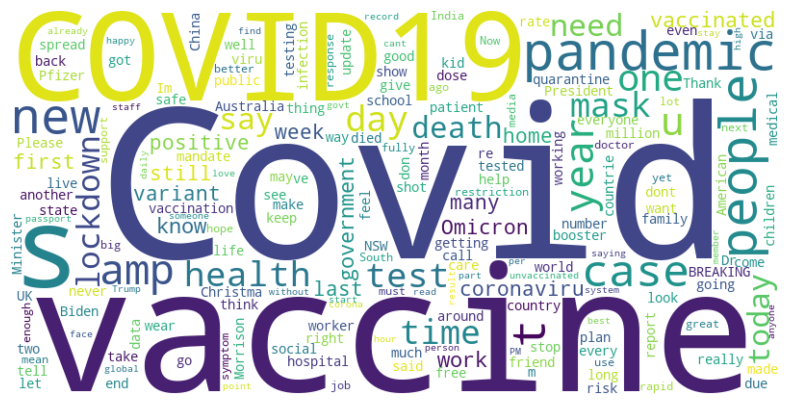

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text into a single string
labeled_df['cleaned_text'] = labeled_df['cleaned_text'].astype(str)
text = " ".join(review for review in labeled_df.cleaned_text)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [7]:
X = labeled_df['cleaned_text']
y = labeled_df['emotion']

vectorizer = TfidfVectorizer()
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Text vectorization
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)  # Fit and transform on training data
X_test_vec = vectorizer.transform(X_test)  # Transform the test data

              precision    recall  f1-score   support

       anger       0.95      0.86      0.91      7163
anticipation       0.95      0.94      0.94     12414
     anxiety       0.98      0.96      0.97     97162
     disgust       0.95      0.72      0.82      1855
        fear       0.95      0.94      0.94      5453
         joy       0.95      0.94      0.94     20235
     neutral       0.94      1.00      0.97     72350
       trust       0.96      0.95      0.95     40430
     worried       0.97      0.96      0.96     40257

    accuracy                           0.96    297319
   macro avg       0.96      0.92      0.93    297319
weighted avg       0.96      0.96      0.96    297319



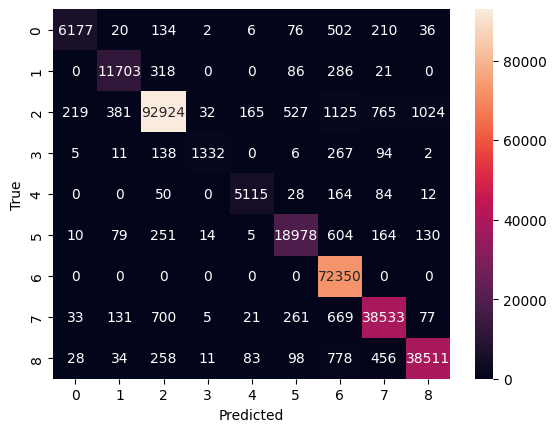

In [8]:
# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

# Predict
y_pred = model.predict(X_test_vec)

# Evaluation
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [9]:
new_data = ["I love this!", "This is terrible."]
new_data_vec = vectorizer.transform(new_data)
new_predictions = model.predict(new_data_vec)
print(new_predictions)

['joy' 'worried']


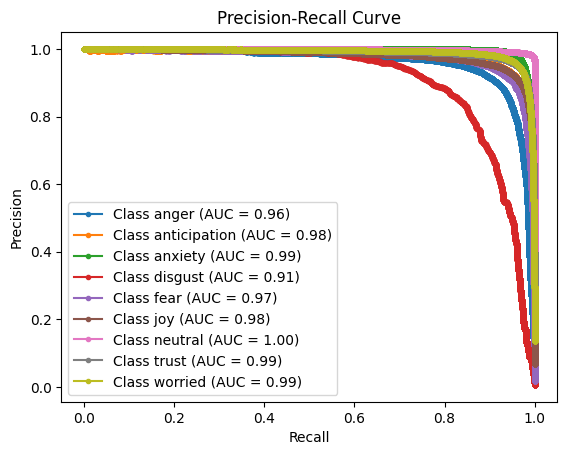

In [14]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc

# Assuming y_test and y_pred are your true and predicted labels
y_test_binarized = label_binarize(y_test, classes=model.classes_)
y_proba = model.predict_proba(X_test_vec)

# Calculate precision-recall for each class
precision = {}
recall = {}
pr_auc = {}

for i in range(len(model.classes_)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_proba[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Plot Precision-Recall curve for each class
for i in range(len(model.classes_)):
    plt.plot(recall[i], precision[i], marker='.', label=f'Class {model.classes_[i]} (AUC = {pr_auc[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

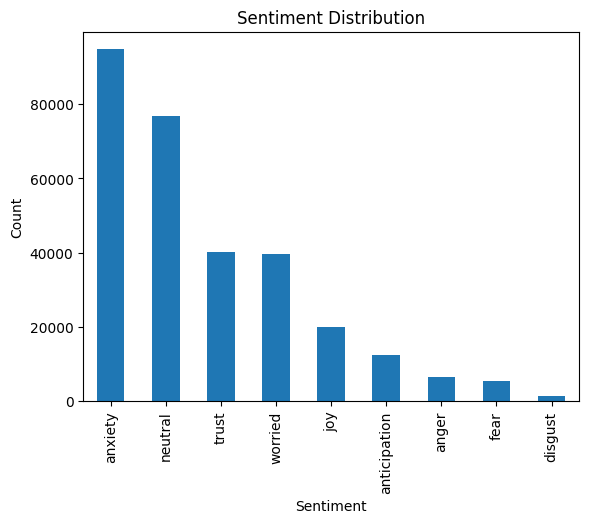

In [15]:
import pandas as pd

# Assuming predictions is a list of predicted sentiments
predictions = model.predict(X_test_vec)
sentiment_counts = pd.Series(predictions).value_counts()

sentiment_counts.plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()
